In [434]:
import numpy as np

from scipy.stats import norm, multivariate_normal
from scipy.special import logsumexp

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
plt.rcParams['figure.dpi'] = 100

In [337]:
# generate parameters of a GMM
k = 2 # num. of gaussians in the mixture
d = 2 # dimensions
weights = np.ones([k])
# weights = np.random.uniform(size=k)
weights /= np.sum(weights)
mu_list = []
cov_mat_list = []
for i in range(k):
    mu = np.random.normal(size=d)
    # variances = np.random.exponential(size=d)
    variances = np.random.uniform(0.01, 0.3, size=d)
    corr_mat = np.random.uniform(size=[d, d])
    corr_mat = np.maximum(corr_mat, corr_mat.T)
    np.fill_diagonal(corr_mat, 5)
    cov_mat = corr_mat * (variances[None, :] * variances[:, None])
    mu_list.append(mu)
    cov_mat_list.append(cov_mat)

In [338]:
def gmm_logpdf(x, weights, mu_list, cov_mat_list):
    n, d = x.shape
    log_probs = np.zeros([n, k])
    for i in range(k):
        norm_lp = multivariate_normal(mu_list[i], cov_mat_list[i]).logpdf(x)
        log_probs[:, i] = np.log(weights[i]) + norm_lp
    total_log_prob = logsumexp(log_probs, axis=1)
    return total_log_prob

# x = np.random.normal(size=[10, d])
# gmm_logpdf(x, weights, mu_list, cov_mat_list)

In [399]:
def rw_metropolis_sampler(logpdf, x0, steps=100):
    n, d = x0.shape
    x_all = np.zeros([n, steps, d])
    x0_lp = logpdf(x0)

    for i in range(steps):
        # propose new position (x1)
        dx = np.random.normal(0, 0.1, size=[n, d])
        x1 = x0 + dx
        x1_lp = logpdf(x1)
        
        # decide whether to accept new position
        u_lp = np.log(np.random.uniform(size=n))
        accept = u_lp < x1_lp - x0_lp
        
        # update current postion (x0)
        x0[accept] = x1[accept]
        x0_lp[accept] = x1_lp[accept]
        # x0 = np.where(do_accept[:, None], x1, x0)
        # x0_lp = np.where(do_accept, x1_lp, x0_lp)
        x_all[:, i] = x0
    
    return x_all

In [424]:
%%time
# set initlial positions for markov chains
n = 30
w = 3
x0 = np.random.uniform(-w, w, size=[n, d])
# x0 = np.zeros([n, d])

# generate markov chains
steps = 1_000
logpdf = lambda x: gmm_logpdf(x, weights, mu_list, cov_mat_list)
walk = rw_metropolis_sampler(logpdf, x0, steps)

CPU times: user 174 ms, sys: 7.48 ms, total: 181 ms
Wall time: 182 ms


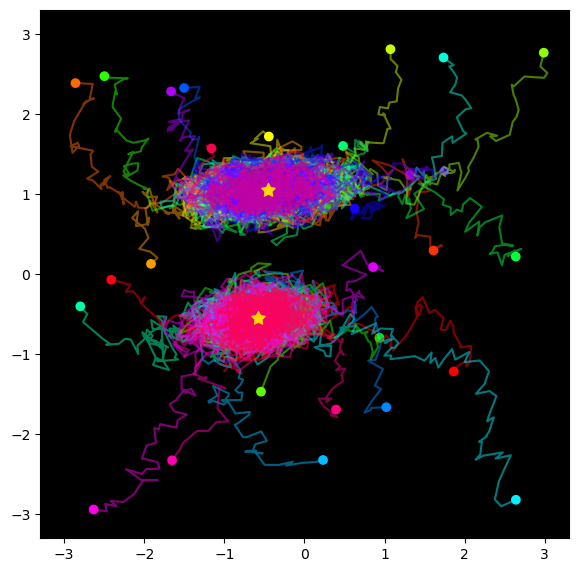

In [435]:
# create coordinate grid
pdf_density = 500
x_range = [-1.1*w, 1.1*w]
y_range = [-1.1*w, 1.1*w]
y, x = np.mgrid[0:pdf_density, 0:pdf_density]
x = x_range[0] + x*((x_range[1] - x_range[0])/(pdf_density-1))
y = y_range[0] + y*((y_range[1] - y_range[0])/(pdf_density-1))

# evaluate density
xy_flat = np.stack([x.flatten(), y.flatten()], axis=-1)
z = np.exp(logpdf(xy_flat))
z = z.reshape(pdf_density, pdf_density)

# plot density
fig, ax = plt.subplots(figsize=[7, 7])
ax.imshow(z, extent=[*x_range, *y_range], origin='lower', cmap='gray', zorder=0)

# plot markov chain
# colors = [mcolors.to_rgba(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
cmap = plt.cm.get_cmap('hsv', n)
colors = [cmap(i) for i in range(n)]
# alpha = np.repeat(np.exp(-np.arange(steps))[None], n, 0)
line_segments = LineCollection(walk, alpha=0.5, colors=colors, zorder=1)
ax.scatter(walk[:, 0, 0], walk[:, 0, 1], c=colors, zorder=1)
ax.add_collection(line_segments)

# plot GMM means
ax.scatter(*np.swapaxes(mu_list, 0, 1), color='gold', marker=(5, 1), s=100, zorder=2)

plt.show()